# Why Some Beers Spark Debate: A Short Walk Through Controversial Brews

## Overview

### 1. Understanding and treating the data (finished)
- **1.1 Data conversion**
- **1.2 Data exploration**
- **1.3 Dataset Merging**
### 2. Exploring the definition of controversiality (in construction)
- **2.1 Ratings and reviews filtering** (in construction)
- **2.? Clustering the beers** (finished)
### 3. Extracting information from the textual reviews (just validate pls)
- **3.1 Sentiment analyses** (finished, but Gustave check pls)
- **3.2 Comparing the distribution with the other attributes** (finished)
- **3.3 Clustering and comparison against the previous clusters** (finished)
### 4. Analyzing some effects of controversiality (in construction)
- **4.1 Effect of the alcohol by volume** (in construction)

Reload necessary functions

In [8]:
from importlib import reload
import src.utils.utils_functions
reload(src.utils.utils_functions)
from src.utils.utils_functions import *

import src.utils.clustering_GMM
reload(src.utils.clustering_GMM)
from src.utils.clustering_GMM import *

import src.utils.aabv_analysis
reload(src.utils.aabv_analysis)
from src.utils.aabv_analysis import *

import src.utils.nbr_rating_analysis
reload(src.utils.nbr_rating_analysis)
from src.utils.nbr_rating_analysis import *

Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import os
from pathlib import Path

from src.utils.utils_functions import *
from src.utils.clustering_GMM import *
from src.utils.aabv_analysis import *
from src.utils.nbr_rating_analysis import *

# Part 1 Understanding and treating the data

## Part 1.1 Data conversion

The first step in our analysis is to ensure all data is represented consistently across the project. This involves converting the original **.txt** files containing ratings and reviews into **.csv** format. Each file was examined carefully, the strings were stored into dictionaries representing key data fields. More details on the conversion process and methodology can be found in **data/TxtToCsv.ipynb**

The CSV files can be found on the following link: https://drive.google.com/drive/folders/1lcRRxlPpcyAcqJzanlwcyb5Vmip0s7_D?usp=sharing
(You will need to ask for permission to see the files)

## Part 1.2 Data exploration

With the data now in a consistent format, we begin exploring deeper the datasets to understand their links and features. We learn especially that some breweries, beers, users matches between the websites. Moreover, their might be duplicates within the datasets, with some users having multiple accounts. Breweries also have duplicates: i.e a single brewery in ratebeer can correspond to up to 3 breweries in advocate. The goal of this notebook was also to look at the percentage of Nan values for the ratings, and to understand the different variables. Further explanations can be found in **data/data_understanding.ipynb**.

Furthermore an other Jupyter Notebook explores Nan values in the dataset. It is mainly a secondary file that was used to evaluate the percentage of Nan in columns of a dataframe. In there we look at the min/max value of the different grades, where we noticed that both datasets not necessarily contain the same range for their grades. More information can be found in **data/data_cleaning.ipynb**.

Some rows contain NaN values in the datasets. Since certain parts of the analysis do not require every feature, we handle missing data filtering based on the requirements of each analysis section.

## Part 1.3 Dataset merging
To enhance the robustness of the analysis, we merge data from both RateBeer and BeerAdvocate. This approach increases the number of ratings per beer enabling a higher reliability and enhancing the controversiality analysis.

The aim is to have a general dataset for users, beers, breweries and ratings. For users, breweries, ratings each one contains a new id, the old id from both datasets except for ratings. It also contains the name, location and other information. If it is match we often make a choice from which dataset to use the information, for example as two breweries in advocate are a single in ratebeer we decided to take the name of the brewery from ratebeer. We filter out the matched informations as a single one.

For ratings we have every rating of both datasets, even the one matched twice. We decided to keep them both as we noticed that comments may differ in the grading and textual description. We added columns corresponding to the new beer, user and brewery id. Certain attributes where deleted as we assumed that we could recompute them again, or if need could reload the old files. Finally we gave an id to each rating, the dataset of origin as 'rb' or 'ad', and we added a column called matched if filled with a number contains the id of the rating it is matched with.

Further information can be found add **data/merge_into_onedataset.ipynb**. The transformed data can be found at the following link:
https://drive.google.com/drive/folders/1McQ7BU24mEsEqouulOPqrmtQJ47E6ZP8?usp=sharing
(You will need to ask for permission).


**Data Loading**

For the whole the next cell calls the different datasets and is used for the rest of the notebook.

In [3]:
root = Path(os.getcwd()).parent

# Files are located in Dataset folder
dataset_path = os.path.join(root,'Dataset')

FULL = "full"
FULL_PATH = os.path.join(dataset_path,FULL)

breweries_df = pd.read_csv(os.path.join(FULL_PATH, 'breweries.csv'))
beers_df = pd.read_csv(os.path.join(FULL_PATH, 'beers.csv'))
users_df = pd.read_csv(os.path.join(FULL_PATH, 'users.csv'))
ratings_df = pd.read_csv(os.path.join(FULL_PATH,'ratings.csv'))
sentiment_df = pd.read_csv(os.path.join(FULL_PATH,'beer_reviews_with_sent.csv'))
sentiment_analysis_df = pd.read_csv(os.path.join(FULL_PATH,'sentiment_analysis.csv'))
ratings_with_sent_df = ratings_df.join(sentiment_df.set_index('id'), on='id')
del sentiment_df

C:\Users\valen\AppData\Local\Temp\ipykernel_9968\604232304.py:10: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_df = pd.read_csv(os.path.join(FULL_PATH, 'beers.csv'))
C:\Users\valen\AppData\Local\Temp\ipykernel_9968\604232304.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv(os.path.join(FULL_PATH, 'users.csv'))


**Grade distribution**

In [ ]:
compute_stastics(ratings_df) # FAUDRAIT MODIFIER CETTE 
# FONCTION POUR QU'ELLE PRINT AVEC DES RETOUR à LA LINE

In [ ]:
plot_var_distrib_violin_grades(ratings_df=ratings_df)

**Grade transformation**
We notice during the data cleaning that grades do not have the same range and resolution on both webistes. 

BeerAdvocate allow the user to rate five attributes (aroma, palate, taste, appearance, overall) on a scale of 1 to 5 with a resolution of 0.25, while RateBeer allow the user to rate aroma and taste between 1 and 10, appearance palate between 1 and 5 and overall between 1 and 20, all with a resolution of 1.

To perform our analysis, we must transform the grades to have the same scale between the two dataset. We decided to set the grade between 1 and 5 as most attributes are graded with this range. This is done by converting RateBeer scales according to the following formula : 

$$ \frac{\text{grade} - \text{min}}{\text{max} - \text{min}} \cdot 4 + 1 $$
- with $\text{max}$ the largest grade one can give to a given attribute.
- with $\text{min}$ the lowest grade one can give to a given attribute.

In [4]:
ratings_df = recompute_grade(ratings_df, min_grade_value = 1, max_grade_value = 5, attributes_of_interest = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'])

**Grade distribution after rescaling**

In [ ]:
plot_var_distrib_violin_grades(ratings_df=ratings_df)

As we can see, it results in attributes having different resolutions. This might be a problem when computing some metrics to define the controversiality and comparing between attributes. This will be discussed further.

# Part 2 Exploring the definition of controversiality

This part aims to determine and label which beers are controversial and which are universal. To do this, we explore different aspects defining the controversiality of a beer. 

What does controversial mean : "subject of intense public argument, disagreement, or disapproval" [1]. As described, this depends on the opinions of the people. As a result, this analysis only depends on the fields the users can fulfill, namely, the different ratings : appearance, aroma, palate, taste, overall, and the textual reviews

We first try to label the beers using the grades provided by the user, later we will try to add the sentiment analysis and observe if it helps in separating the beers.

## Part 2.1 Ratings and reviews filtering

As mentioned earlier, controversiality depends on disagreement in opinions. Beers with few ratings are more likely to show high variability (e.g. two opposing opinions). To ensure reliable insights and meaningful analysis, we exclude beers with fewer number of ratings or reviews than a specified threshold. (((((((((((Later, we might apply a weighting factor based on rating count to further refine the controversiality analysis, according more importance to more rated beers.)))))))))))

Let's try to find a reasonable threshold.



In [ ]:
test_threshold_filtering(ratings_df)

The choice of the threhsold is : x

In [5]:
beer_ratings, breweries_df, beers_df, users_df = filter_ratings_new(ratings_df, beers_df, breweries_df,users_df, threshold=10, attributes=['appearance', 'aroma', 'palate', 'taste', 'overall'])

Pourcentage of ratings remaining after dropping rows with nan values in selected attributes: 76.65 %
Pourcentage of ratings remaining after dropping rating for which beer has too few valid ratings : 68.65 %
Pourcentage of beers remaining after dropping rating for which a beer has too few valid ratings : 21.98 %
Pourcentage of breweries remaining after dropping rating for which a beer has too few valid ratings : 38.30 %
Pourcentage of users remaining after dropping rating for which a beer has too few valid ratings : 73.13 %


In [6]:
#I just need it for the rest of the code. So add it where you want, or where it will be used.
attributes_variance = compute_variance_per_attribute(beer_ratings, ['appearance', 'aroma', 'palate', 'taste','overall'])

## Part 2.? Clustering the beers

Through are previous analysis we did not find any easy threshold, therefore we decided to apply a Gaussian Mixture Model (GMM) to the variance of our beers. Let us first perform a GMM analysis from 1 to 10 clusters and look at the negative log-likelihood of our clustering.


In [ ]:
plot_nll(attributes_variance, min = 1, max = 10)

By applying the elbow method the plot of the negative log likelihood, with a varying number of clusters, we see that the optimal number of clusters would we 3. This is perfect since, at the end we would like to have three clusters corresponding to universal, neutral and controversial. Now let's have a look at what the clusters are to attribute the various labels to a cluster.

Started plotting
Finished plotting


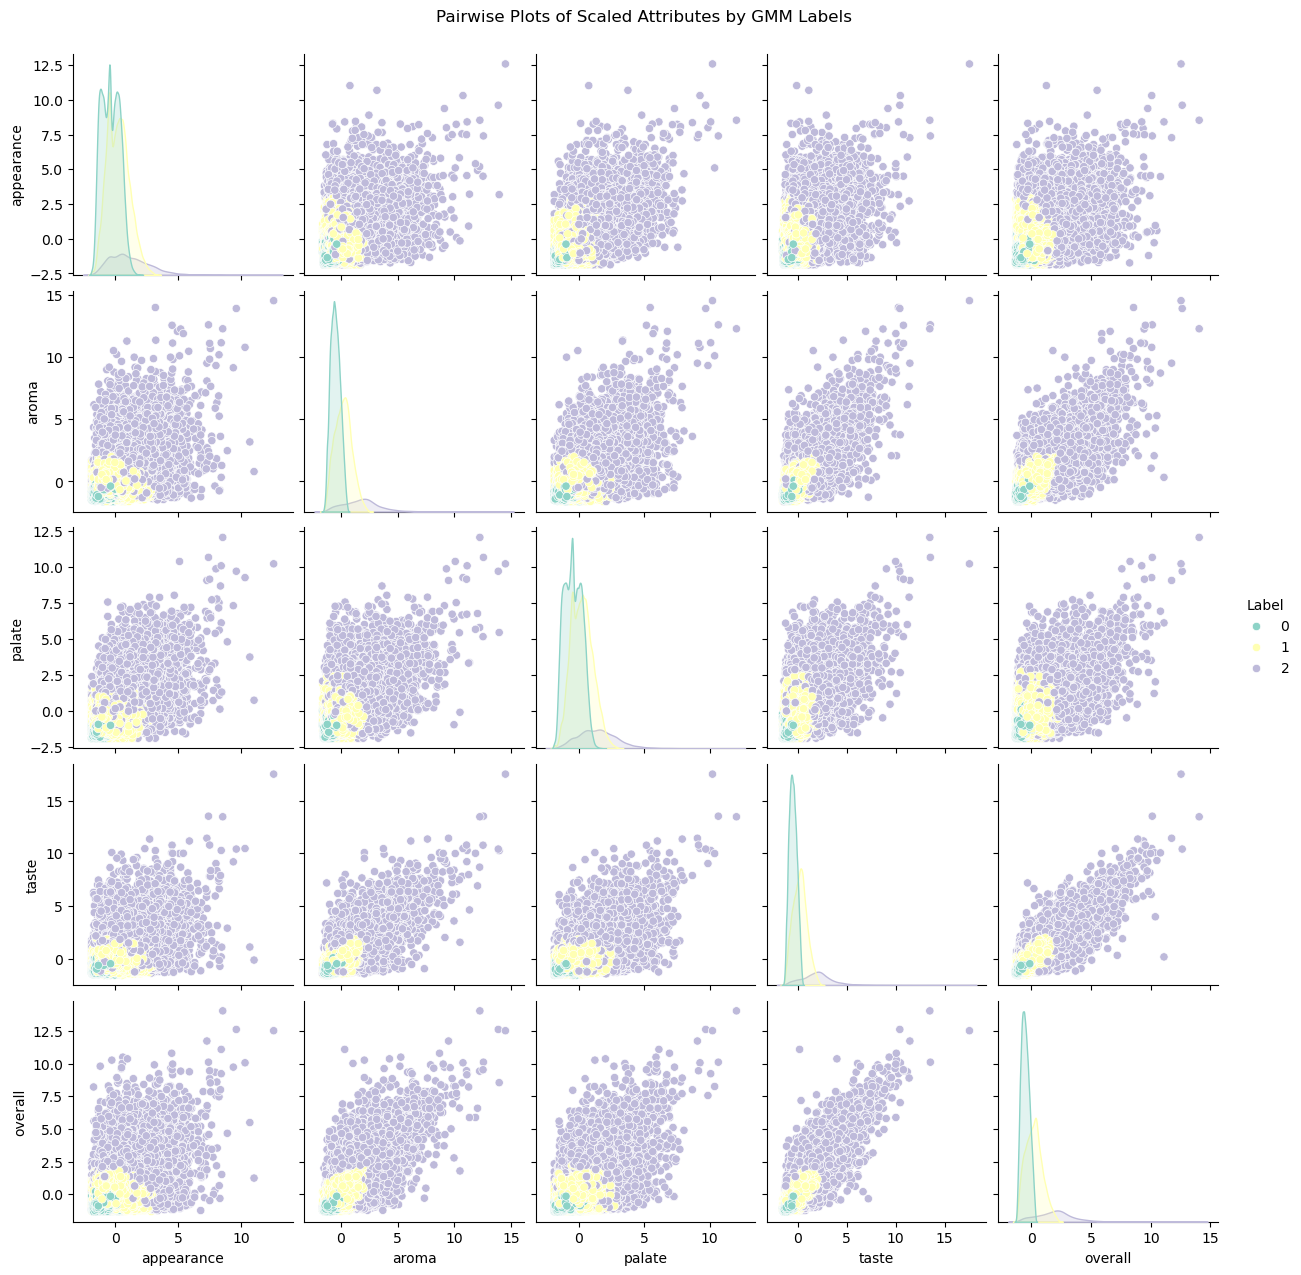

In [7]:
labels = visualize_gmm_all_dimensions(attributes_variance, n_components_gmm=3)

In [ ]:
print_label_statistics(labels)

Note that the clusters where computed on the variance scaled to 0 mean and 1 as a standard deviation. 

Our definition of controversiality is that a beer is controversial if it has a high various across ratings, and a universal beer is a beer which has low variance across its ratings. The values appearing on the plot are not the real ones, just the scaled variances. As our variances are positive, we assume that the smallest "scaled variances" are the ones that where near 0, and the bigger ones are the ones with a higher variance. So by using the definition we can define the clusters as the following:
- 0 : neutral, which represents 55.42% of the beers with a sufficient amount of ratings
- 1 : controversial, which represents 23.11% of the beers with a sufficient amount of ratings
- 2 : universal, which represents 21.47% of the beers with a sufficient amount of ratings


# Part 3 Extracting information from the textual reviews

In the previous part we used almost every aspect that the rater could grade. However we did not use the textual analyses provided by the graders. In this part we aim at choosing a model to perform sentiment analyses, and to observe if the use of the score of the sentiment analyses can further enhance the separation of the different beers into controversiality/universality.


## Part 3.1: Sentiment Analysis

We will begin by performing a sentiment analysis on the reviews. This will help us gain deeper insights when we later classify the reviews by topics. The primary objective is to identify a reliable, multilingual model. To achieve this, we will compare the performance of various models:  A [BERT base multilingual uncased model](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment), [Google Cloud NLP](https://cloud.google.com/natural-language/docs/analyzing-sentiment?hl=fr), [GPT-4o mini](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) and a 
[distilbert base multilingual cased model](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student).

We will compare the performance of each model on the first 6,000 reviews. We chose 6,000 reviews because it is a large enough sample for a minimally biased analysis while helping save on API credits.

Each review was labeled as Positive (1), Neutral (0), or Negative (-1).  We kept the result of this analysis in the [_sentiment_analysis.csv_](https://drive.google.com/file/d/1attiqoXvTSruf6DDXodvU7jFvLKZCOHr/view?usp=sharing) file.

We then compared the models’ performances based on exact similarity and similarity within a range of ±1. The latter is particularly relevant because it allows us to identify models that may produce false positives or false negatives.

In [8]:
[df, exact_similarity_columns, plus_minus_1_similarity_columns] = compute_similarity_scores(sentiment_analysis_df)

We decided to plot the result in the following bar plots for the exact and ±1 similarity scores across different pairs.

In [ ]:
plot_sentiment_similarities(df, exact_similarity_columns, plus_minus_1_similarity_columns)

First, looking at the bar plots, the BERT and Distlilbert, the Google Cloud NLP and GPT-4o mini models, as well as the BERT anf Google Cloud NLP models show the highest similarity for exact sentiment, exceeding 65%.

Additionally, the Google Cloud NLP and GPT-4o mini models have nearly 100% similarity when considering a margin, followed closely by the BERT-based model and GPT-4o mini, and then by the DistilBERT model and GPT-4o mini.

Given that GPT-4o mini, the BERT model and Google Cloud NLP are very similar in the second graph, that GPT-4o mini is falling behind in the exact sentiment comparison and the DistilBERT model is behind the other models in both comparisons, we should use either Google Cloud NLP or the BERT-based model. Even though Google Cloud NLP has a slightly better similarity in both comparisons, it also an expensive api for large datasets. We will therefore use the BERT-based model for the final sentiment analysis.

## Part 3.2: Comparing the distribution with the other attributes

Now that we have a sentiment score for the comments with a textual review we can compare the distribution with the other grades. We want to see if it adds information, or if it is related with another attribute. For this we first need to recompute the grades provided by the sentiment analysis as the score is between -1 and 1. We can then filter the remaining beers and perform our statistical analysis.

In [ ]:
#Recomputes the grades
ratings_df_with_sent = recompute_grade(ratings_with_sent_df, min_grade_value = 1, max_grade_value = 5, attributes_of_interest = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating','sentiment_bert'])
#Filters the remaining beers, breweries, users and ratings
beer_ratings_new_sent,breweries_df_new_sent, beers_df_new_sent, users_df_new_sent = filter_ratings_new(ratings_df_with_sent, beers_df, breweries_df,users_df, threshold=10, attributes=['appearance', 'aroma', 'palate', 'taste', 'overall','sentiment_bert'])
#Computes the variance of the various attributes of interest
attributes_variance_sent = compute_variance_per_attribute(beer_ratings_new_sent, ['appearance', 'aroma', 'palate', 'taste','overall','sentiment_bert'])

We note that by keeping only comment with a textual description, we keep 19.22% of the initial beers. However we still keep 56.10% of the comments.

As mentioned previously we want to test if the distribution of the variance provided by the sentiment analysis is similar to the distribution of another attribute. Therefore, we decided to perform a T-Test statistic to evaluate this hypothesis. The T-Test is applied on the variance of each attribute. The H0 hypothesis is that the true mean of the variance of a given attribute between the different beers are equal. H1 is that the means are different.
We decided to plot the results in a Heatmap where the value is the p-value of the statistical test between the variance of two attributes. The diagonal should be 1 as it is twice the same distribution.

In [ ]:
t_test_statistic(attributes_variance_sent, attributes_of_interest = ['appearance', 'aroma', 'palate', 'taste','overall','sentiment_bert'])

From the previous plot we can reject the H0 every time with a significance level of 5%. This means that the sentiment analysis provide further information, than the attributes we already have. We now want to see how variance of the sentiment score is correlated with the other attributes.

In [ ]:
correlations = compute_correlation(attributes_variance_sent, ['sentiment_bert'])
plot_correlation(correlations, 'Correlation of attributes variances with the variance of the sentiment analysis')

From the above plot we see that the sentiment score variance is positively correlated with all the other attributes. Every correlation is around 0.4, however the appearence is particularly low at around 0.31. This could tell us that the textual review does not provid einformation abou the appearence. However such hypothesis would need to be studied more carefully with keywords analysis.

## Part 3.3: Clustering and comparison against the previous clusters

In part 2, we clustered the beers using GMM on certain attributes. Now we can add the information provided by the sentiment analysis and compare the different clusters. We aim at evaluating the clusters choosing how we will define controversiality for the rest of our analysis. Now lets us first perform the GMM clustering, we decided to use three clusters since we already used 3 clusters for the previous clustering.

JE DEMANDE QUAND MEME ON MET LA ELBOW METHOD AUSSI, OU LA JUSTIFICATION DITES AU DESSUS SUFFIT? @Jehan

In [ ]:
labels_sent = visualize_gmm_all_dimensions(attributes_variance_sent, n_components_gmm=3)

Just like in the previous part, we see with the plots what the different clusters look like across the various attributes. By using the definition of controversiality, which would be that a higher variance indicates controversiality, whereas a near 0 variance indicates universality. From this we determine that in the case of sentiment analysis, that the clusters are the following:
- 0 : neutral
- 1 : universal
- 2 : controversial

Note that for plotting purposes and for the GMM computation that the variance where scaled to have 0 mean and 1 of variance. Therefore the values appearing on the plot are not the real ones, just the scaled variances. As our variances are positive, we assume that the smallest "scaled variances" are the ones that where near 0, and the bigger ones are the ones with a higher variance. 

Now we want to compare the two clustering made and see if they differ or not. The comparison will be done on the beers which contain a textual review.


In [ ]:
compare_two_clustering(attributes_variance, attributes_variance_sent, labels, labels_sent, [2,0,1], [1,0,2])


We see that clusters do not match at all. For this we believe the cause is coming from the sentiment score. During the evaluation process of the model we saw that we had 66% of perfect accuracy if the texts are classified as 0,-1 or 1. Therefore it introduces a higher variance since we are not sure about the final score. We also see that number of beers per label differs from the initial clustering. In the end we would need real labels to have a sentiment score which would serve as ground truth and on which we could rely. For all this reason we decide to pursue the analysis of the next parts with the clusters discovered in part 2.

In conclusion, sentiment analysis provides another attribute which is different from the other attributes filled in by the grader. However we need more accurate results or at least results on which we could rely more to be confident in using them for the next step of this analysis.

# Part 4 Analyzing some effects of controversiality

After having labelled the various beers into three categories, we want to have a look at some underlying factors behind the variance of the grading of some beers. We want to analyze the effect of the alcohol by volume, the number of ratings of the beer, the level of expertise of the grader and the origin of the grader/beer. By level of expertise, we mean that we want to separate them into three categories, which we will delve into later. 

## Part 4.1 Effect of the alcohol by volume

One attribute that we have for the beers is the alcohol by volume (abv) level of the beers. We want to test the correlation between the abv and the frequency of a beer being labeled as controversial. 

First let us look at the distribution of beers with a certain amount of abv, and the porportion of each each class corresponding to an abv level. 

c:\Users\valen\OneDrive\Documents\MA 3\CS 401\ada-2024-project-abracadabra\src\utils\aabv_analysis.py:74: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



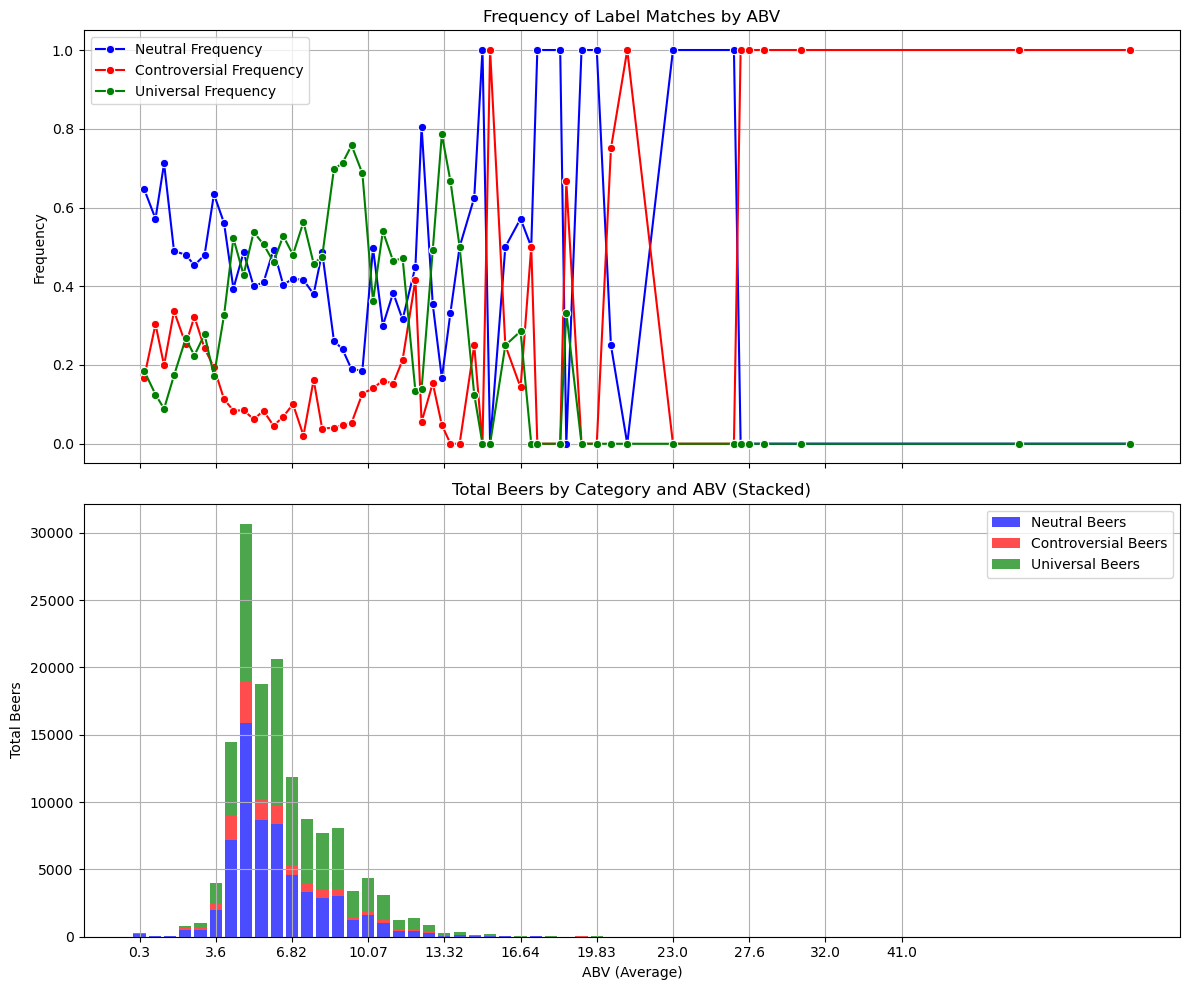

In [26]:
import src.utils.aabv_analysis
reload(src.utils.aabv_analysis)
from src.utils.aabv_analysis import *

range_grouped_abv = plot_distribution_rating_abv(attributes_variance, beers_df[['id','abv']], labels, save = False, interactive = False)

# 2ND PLOT IS WRONG CORRECT IT WARNING IMAGE (I plotted the none interactive since the interactive values are wrong)

From the plot we notice a big amount of beers having an abv between 0 and 15. Furthermore after 22, since the beers with enough ratings become less frequent, we notice a bigger oscillation between the proportions. On other observation can be made that at high abv, the beers are more frequently classified as controversial. However the results needs to be taken with a grain of salt, since we have very few beers at this level. 

We now want to compute the correlation between the abv level and the proportion of the classified beers but also the total number of beers. We will do this for the beers with an abv smaller than 22, as we believe the oscillation could falsify our results.

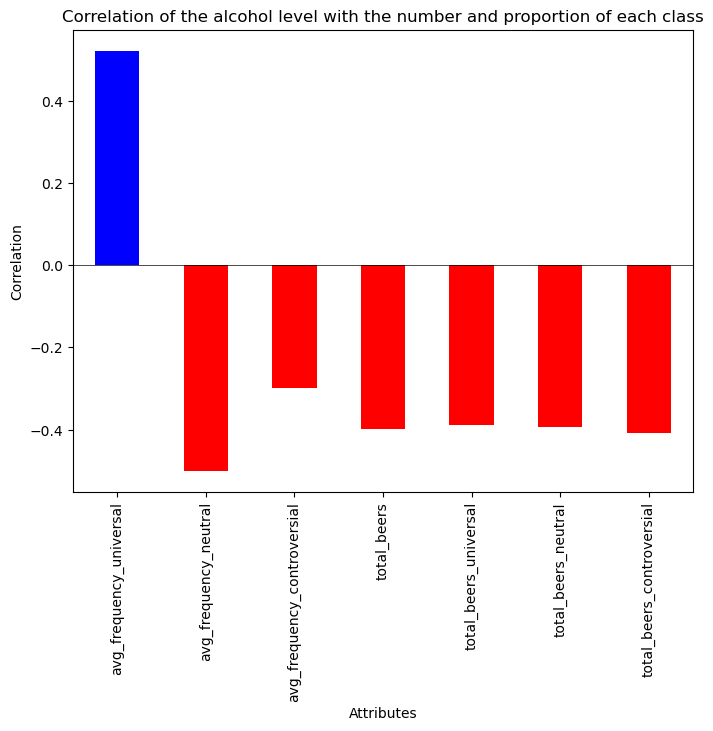

In [14]:
correlations = compute_correlation(range_grouped_abv[range_grouped_abv.avg_abv<20].drop(columns='abv_range'), ['avg_abv'])
plot_correlation(correlations, title = 'Correlation of the alcohol level with the number and proportion of each class')

From the above plot we see that without any surprise the number of beers in total and for each class is negatively correlated with the abv. However more suprisingly the abv is positively correlated with the average frequency of the universal beers. This can lead us to believe that of to 20, if the abv increasis then the beer becomes more universal.

# Do we do the analysis for the beers with abv >20 (or whole) ?